In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
prearticles = pd.read_csv('analysis.csv')
#print(prearticles.shape)

In [3]:
titles = prearticles['Title']
print(titles[:10])
synopses = prearticles['text']
print(synopses[0][:200])

0                        A Big Deal for Conservation
1                                  Collective Impact
2                              Creating Social Value
3                                   Luck of the Draw
4                          Partnerships for Learning
5                   Reshaping Social Entrepeneurship
6    Social Entrepeneurship: The Case for Definition
7                      Sparking Nonprofit Innovation
8                      The Dawn of System Leadership
9                        The Hidden Cost of Paradise
Name: Title, dtype: object
A Big Deal for Conservation By Larry Linden Steve McCormick Ivan Barkhorn Roger Ullman Guillermo Castilleja Dan Winterson & Lee Green    Summer 2012  _ 2012 by Leland Stanford Jr. University All Right


In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#############################################################################################
stop_words.extend(['from', 'also', 'would', 'say', 'percent', 'year', 'mention', 'make_sure', 'enough',
                   'yet', 'next','instead','perhaps', 'purely','thompson', 'matthew', 'charle', 'october', 'onetime',  'olivia', 'come', 'mike',  'martin',  'poorly', 
                   'rainy_day',  'way', 'many', 'often', 'make', 'give',  'use',   'may','great', 'well',
                   'take', 'see', 'provide', 'time', 'example', 'good', 'feel', 'large', 'mark', 'include', 'sai', 'lalao', 'coffee', 'usaid',
                   'become', 'get', 'high', 'stay', 'day', 'cut', 'increase', 'even', 'number', 'organization', 'process', 'result', 'affiliate', 
                   'offer', 'ict', 'white', 'jackson','susan','go','first','second'])

In [5]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [6]:
#define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [7]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [8]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print (vocab_frame.head())

there are 1006264 items in vocab_frame
                words
a                   a
big               big
deal             deal
for               for
conserv  conservation


### Tf-idf and document similarity

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

E:\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'s", 'abov', 'affili', 'ani', 'becaus', 'becom', 'befor', 'charl', 'coffe', 'could', 'doe', 'dure', 'exampl', 'includ', 'increas', 'larg', 'make_sur', 'mani', 'might', 'must', "n't", 'need', 'octob', 'onc', 'onetim', 'onli', 'organ', 'ourselv', 'perhap', 'poor', 'provid', 'pure', 'sha', 'themselv', 'veri', 'whi', 'wo', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 21.5 s
(233, 2186)


In [10]:
terms = tfidf_vectorizer.get_feature_names()

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering

In [49]:
from sklearn.cluster import KMeans

num_clusters = 10

#km = KMeans(n_clusters=num_clusters,max_iter=2000, n_init=30,tol=1e-5)

#km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 32 s


In [11]:
from sklearn.externals import joblib

#save model 

#joblib.dump(km,  'doc_cluster.pkl')

#load model
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [17]:
Tools = prearticles['PRIMARY TOOL CODE:  EXPLORE=1, FINANCE=2, DESIGN=3, ADVOCACY=4, DELIVER=5']
Tasks = prearticles['PRIMARY TASK CODE: CALL=11, MAP=12, INVEST=21, PROSPECT=22, COLLECT=31, COMBINE=32, FRAME=41, RATIFY=42, SCALE=51, DISRUPT=52']

In [18]:
arts = {'title': titles,  'synopsis': synopses,
        'cluster': clusters, 'Tool': Tools, 'Task': Tasks}
#titles = pd.Series[titles]
#clustersss = pd.Series[clusters]
frame = pd.DataFrame(data=clusters,columns={'Cluster'})
frame = frame.assign(Title=titles,Tool = Tools, Task = Tasks)

print(frame.head(10))

   Cluster                                            Title  Tool  Task
0        0                      A Big Deal for Conservation     3    31
1        0                                Collective Impact     3    32
2        5                            Creating Social Value     1    11
3        9                                 Luck of the Draw     1    11
4        1                        Partnerships for Learning     2    22
5        5                 Reshaping Social Entrepeneurship     1    11
6        5  Social Entrepeneurship: The Case for Definition     1    11
7        4                    Sparking Nonprofit Innovation     1    11
8        4                    The Dawn of System Leadership     1    12
9        4                      The Hidden Cost of Paradise     4    41


In [67]:
#save cluster to excel
#frame.to_excel('kmeandata.xlsx')

In [19]:
frame['Cluster'].value_counts() #number of articles per cluster 

4    55
2    38
1    29
0    24
5    19
8    17
7    17
3    14
9    12
6     8
Name: Cluster, dtype: int64

In [20]:
num_clusters = 10
print("Top 15 terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 


for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :15]: 
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()


Top 15 terms per cluster:
Cluster 0 words: b'donors', b'foundations', b'media', b'collaborative', b'philanthropy', b'nonprofit', b'fund', b'impact', b'public', b'alliances', b'campaign', b'engage', b'conservation', b'projects', b'government',
Cluster 1 words: b'company', b'corporate', b'sustain', b'environmental', b'lobby', b'market', b'employees', b'consumers', b'products', b'issues', b'government', b'activists', b'public', b'conservation', b'nonprofit',
Cluster 2 words: b'nonprofit', b'fund', b'board', b'for-profit', b'government', b'funders', b'brands', b'mission', b'donors', b'cost', b'sector', b'capitalized', b'models', b'foundations', b'market',
Cluster 3 words: b'loans', b'microfinance', b'poorly', b'banking', b'clients', b'poverty', b'saving', b'rate', b'market', b'poorly', b'products', b'borrow', b'education', b'profit', b'financial',
Cluster 4 words: b'innovations', b'teachers', b'school', b'communities', b'designation', b'students', b'network', b'problems', b'learned', b'ide

In [21]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [22]:
# set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}

# set up cluster names using a dict
cluster_names = {0: '0', 1: '1',  2: '2', 3: '3', 4: '4',
                 5: '5', 6: '6', 7: '7',  8: '8', 9: '9'}

E:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


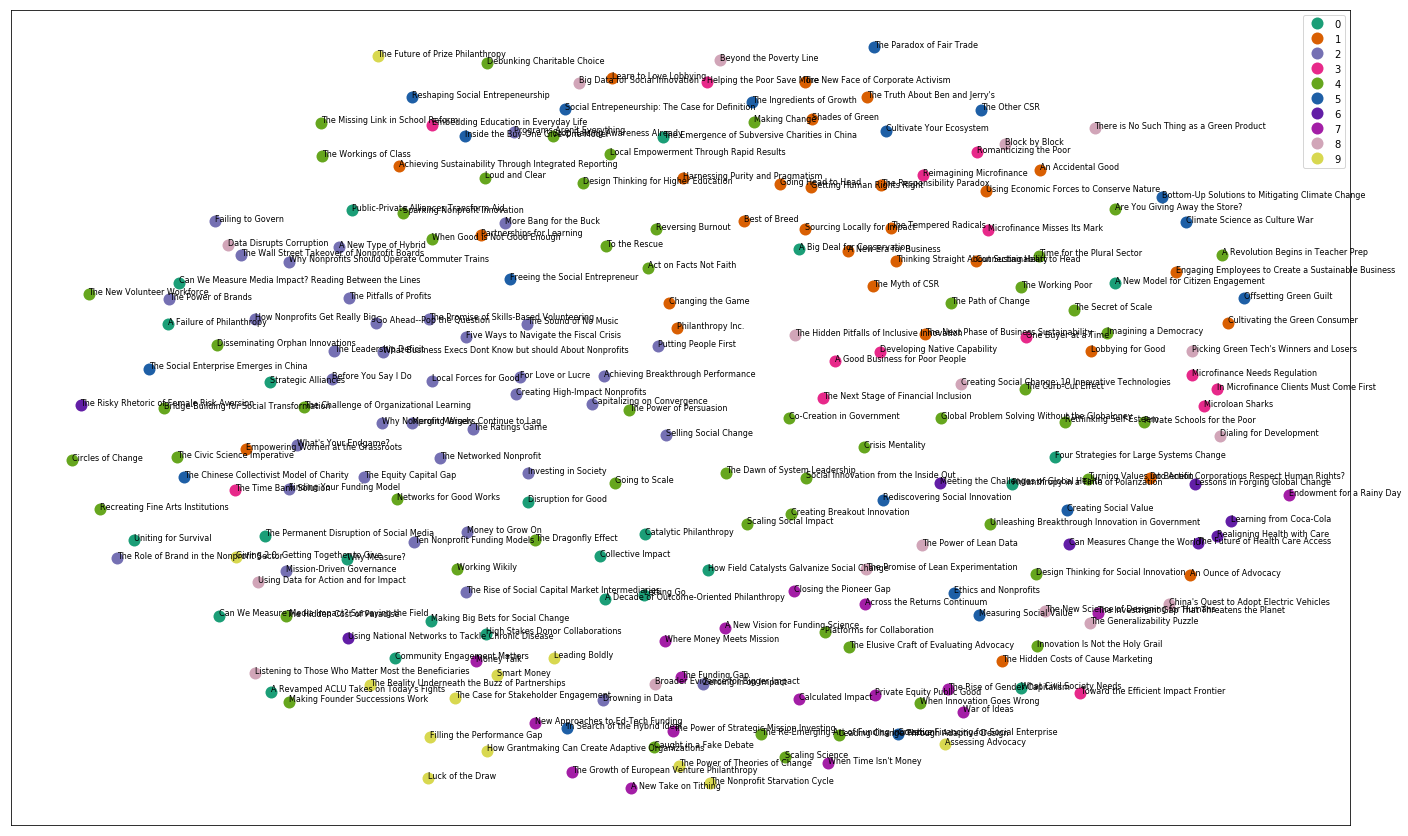

In [23]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(24, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

    
    
plt.show() #show the plot

In [24]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [35]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

fig, ax = plt.subplots(figsize=(14,9)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot
mpld3.save_html(fig,'kmeanscatterplot.html')



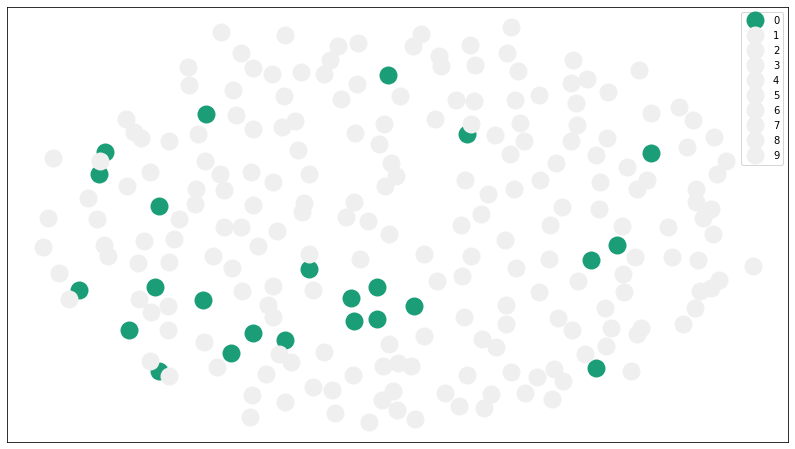

In [26]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#1b9e77', 1: '#efefef', 2: '#efefef', 3: '#efefef', 4: '#efefef',
                  5: '#efefef', 6: '#efefef', 7: '#efefef', 8: '#efefef', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot0.png')

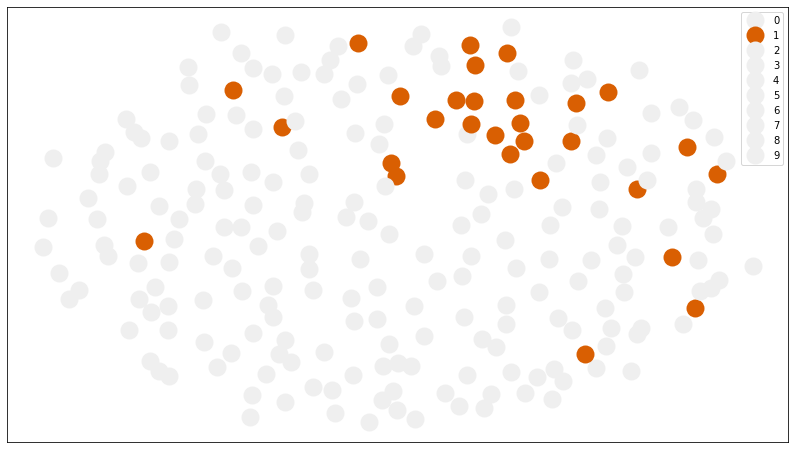

In [27]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#d95f02', 2: '#efefef', 3: '#efefef', 4: '#efefef',
                  5: '#efefef', 6: '#efefef', 7: '#efefef', 8: '#efefef', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot1.png')

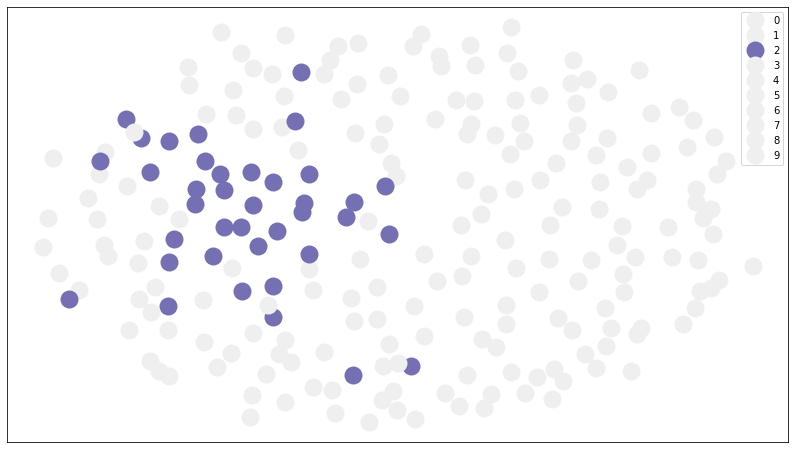

In [28]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#7570b3', 3: '#efefef', 4: '#efefef',
                  5: '#efefef', 6: '#efefef', 7: '#efefef', 8: '#efefef', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot2.png')

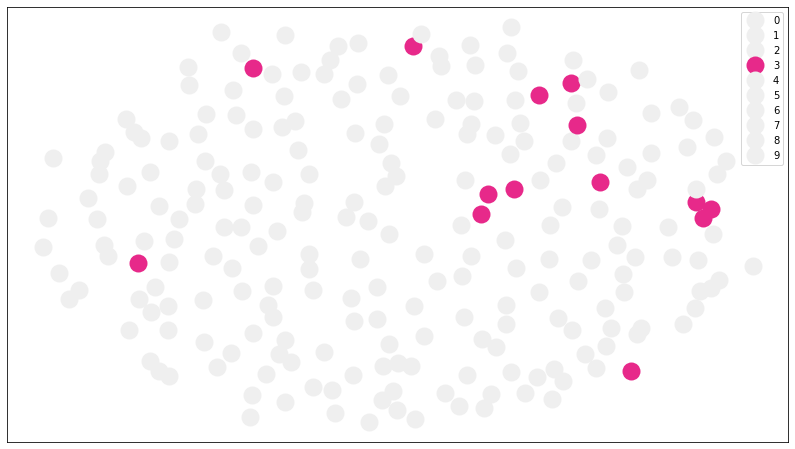

In [30]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#efefef', 3: '#e7298a', 4: '#efefef',
                  5: '#efefef', 6: '#efefef', 7: '#efefef', 8: '#efefef', 9: '#efefef'}

fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot3.png')

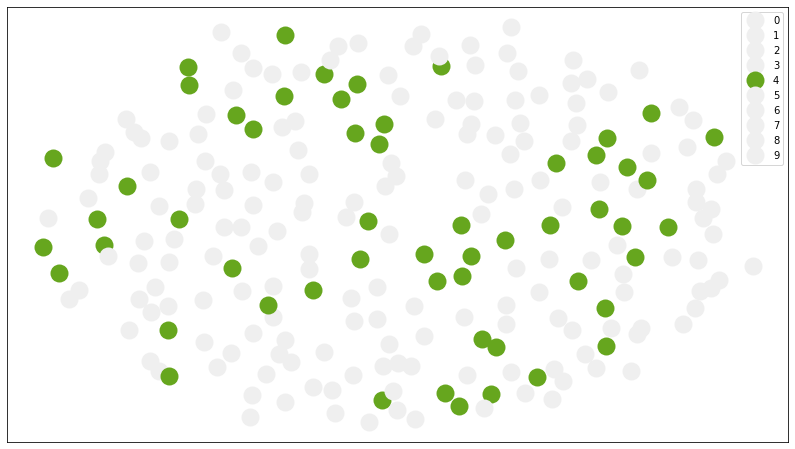

In [31]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#efefef', 3: '#efefef', 4: '#66a61e',
                  5: '#efefef', 6: '#efefef', 7: '#efefef', 8: '#efefef', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot4.png')

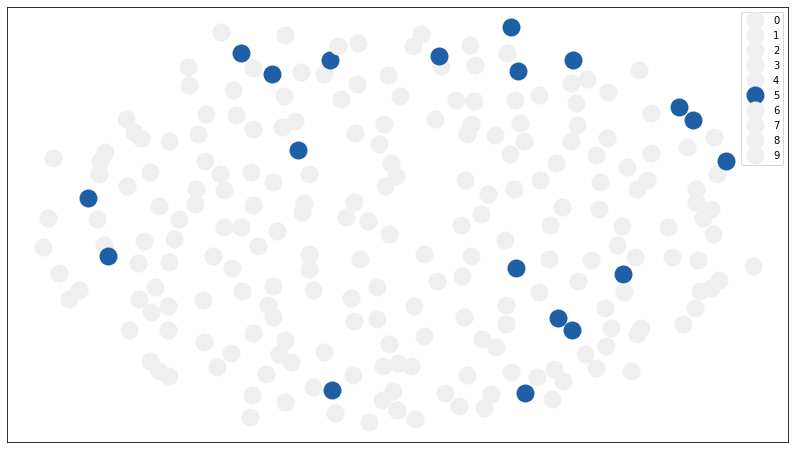

In [32]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#efefef', 3: '#efefef', 4: '#efefef',
                  5: '#1e5fa6', 6: '#efefef', 7: '#efefef', 8: '#efefef', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot5.png')

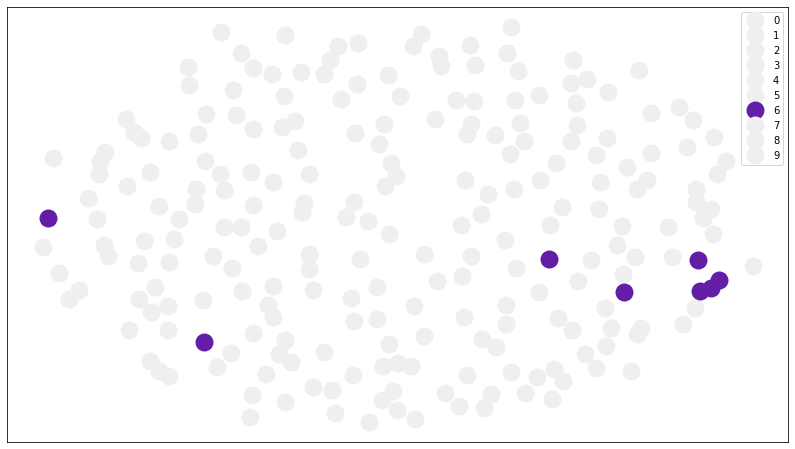

In [33]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#efefef', 3: '#efefef', 4: '#efefef',
                  5: '#efefef', 6: '#621ea6', 7: '#efefef', 8: '#efefef', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot6.png')

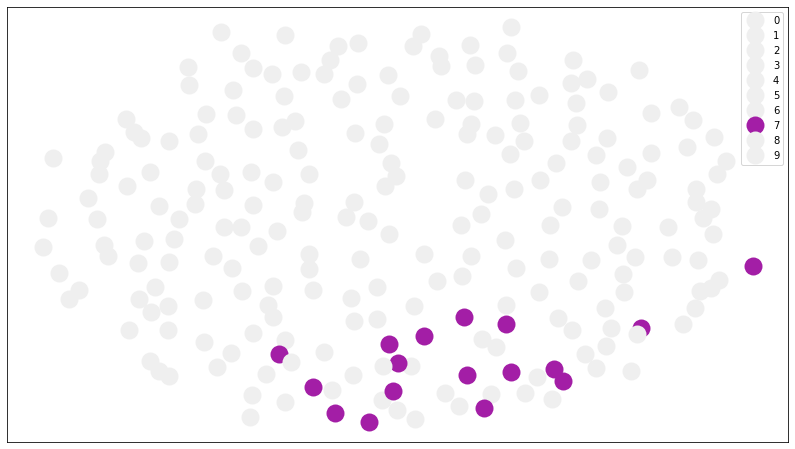

In [34]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#efefef', 3: '#efefef', 4: '#efefef',
                  5: '#efefef', 6: '#efefef', 7: '#a31ea6', 8: '#efefef', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot7.png')

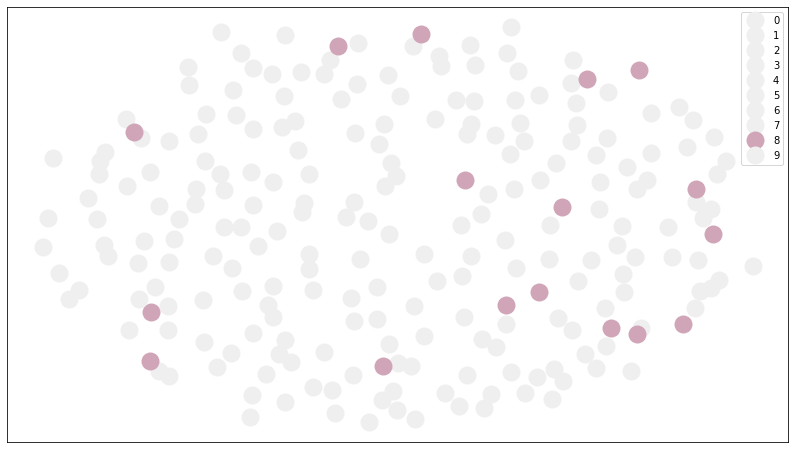

In [35]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#efefef', 3: '#efefef', 4: '#efefef',
                  5: '#efefef', 6: '#efefef', 7: '#efefef', 8: '#d1a5b8', 9: '#efefef'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot8.png')

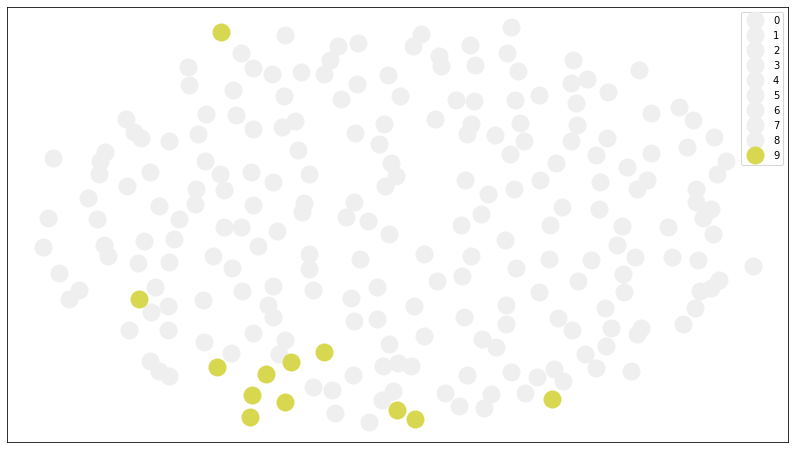

In [36]:
# set up colors per clusters using a dict
#cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e',
#                  5: '#1e5fa6', 6: '#621ea6', 7: '#a31ea6', 8: '#d1a5b8', 9: '#d8d850'}
cluster_colors = {0: '#efefef', 1: '#efefef', 2: '#efefef', 3: '#efefef', 4: '#efefef',
                  5: '#efefef', 6: '#efefef', 7: '#efefef', 8: '#efefef', 9: '#d8d850'}
# black #000000

# Plot
fig, ax = plt.subplots(figsize=(14, 8))  # set plot size
# ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

# iterate through groups to layer the plot
# note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18,
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]

    # set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                             voffset=10, hoffset=10, css=css)
    # connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())

    # set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    # set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


ax.legend(numpoints=1)  # show legend with only one dot

fig.savefig('plot9.png')

In [1]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.01809096755035221


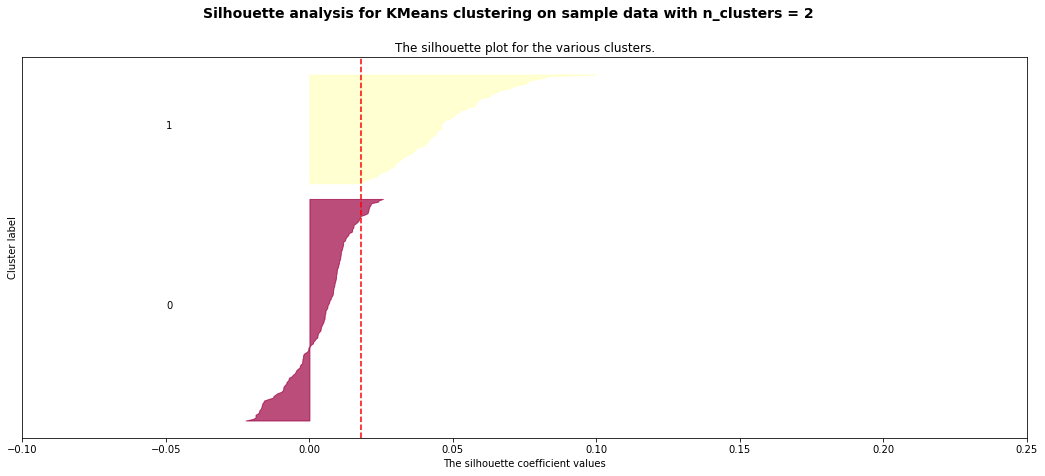

For n_clusters = 3 The average silhouette_score is : 0.02027967545815372


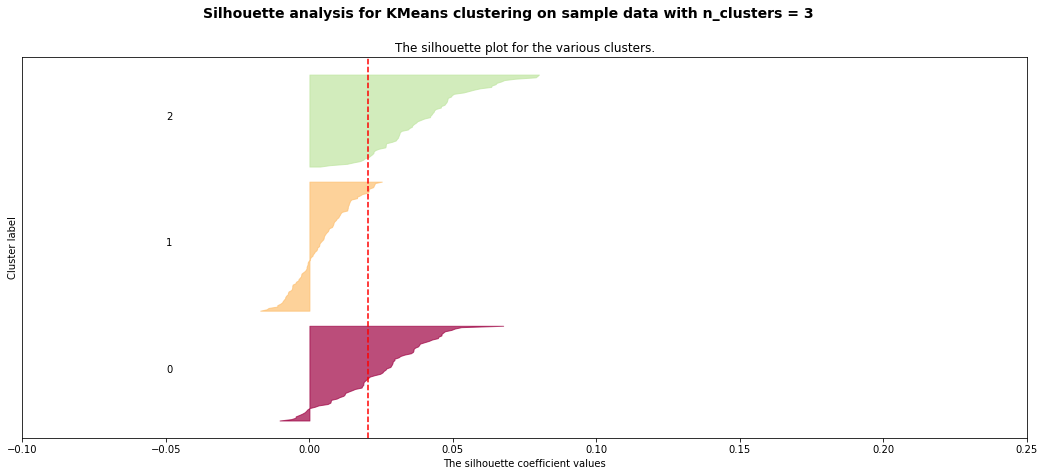

For n_clusters = 4 The average silhouette_score is : 0.019579725486279873


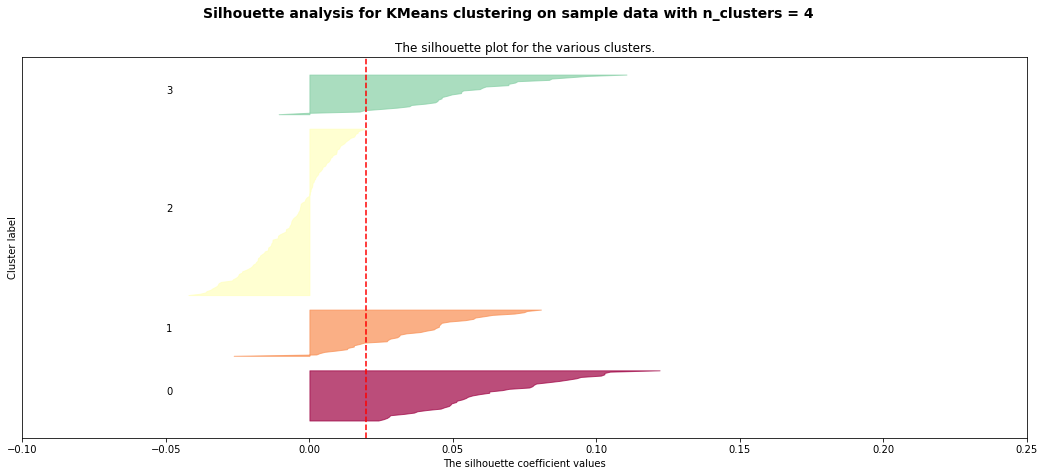

For n_clusters = 5 The average silhouette_score is : 0.020804531028335436


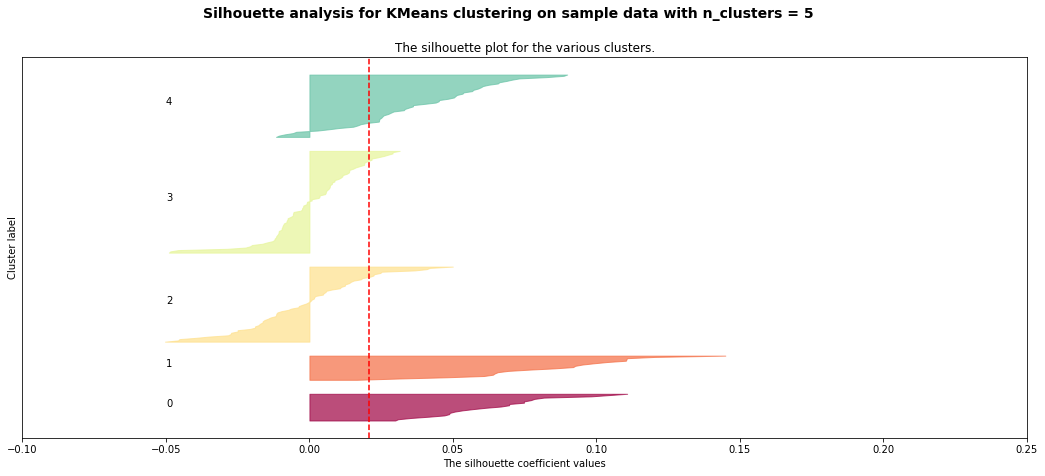

For n_clusters = 6 The average silhouette_score is : 0.024398475870632035


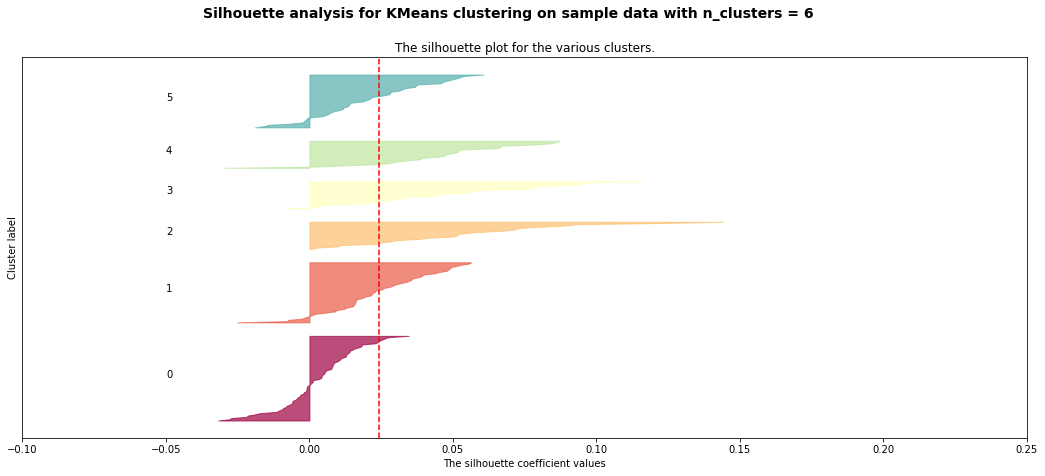

For n_clusters = 7 The average silhouette_score is : 0.02686430535205623


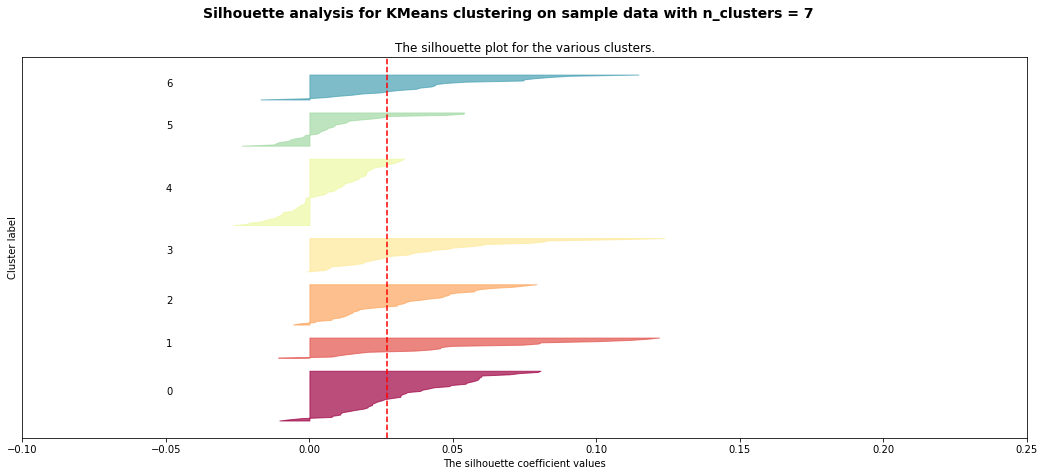

For n_clusters = 8 The average silhouette_score is : 0.025813674487533064


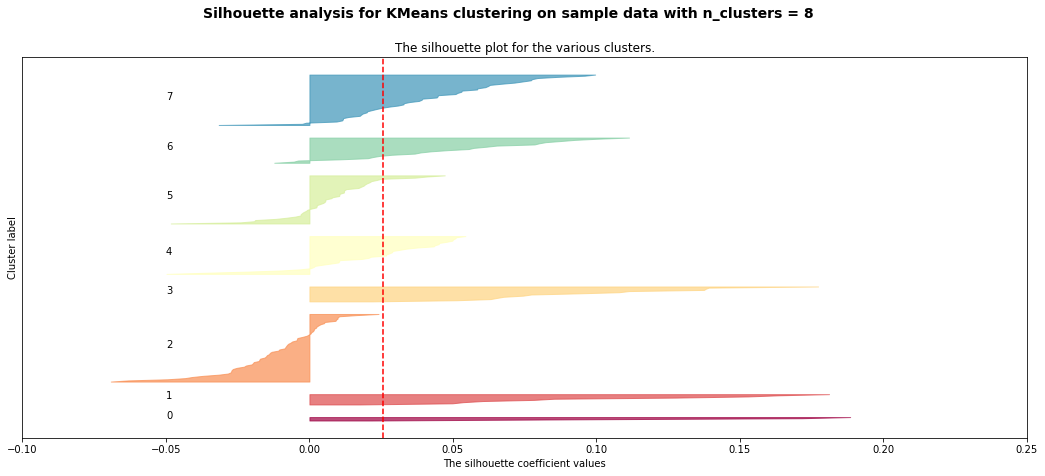

For n_clusters = 9 The average silhouette_score is : 0.02752714466218912


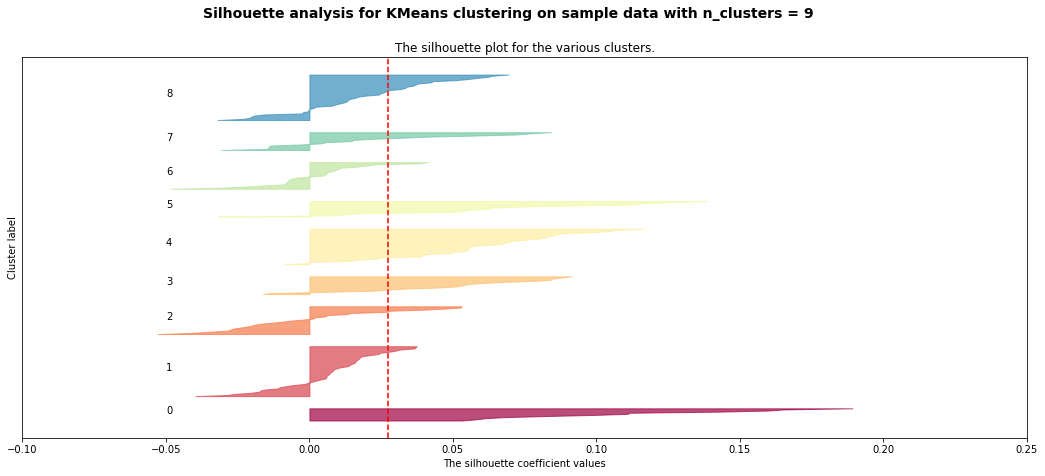

For n_clusters = 10 The average silhouette_score is : 0.025438605419956403


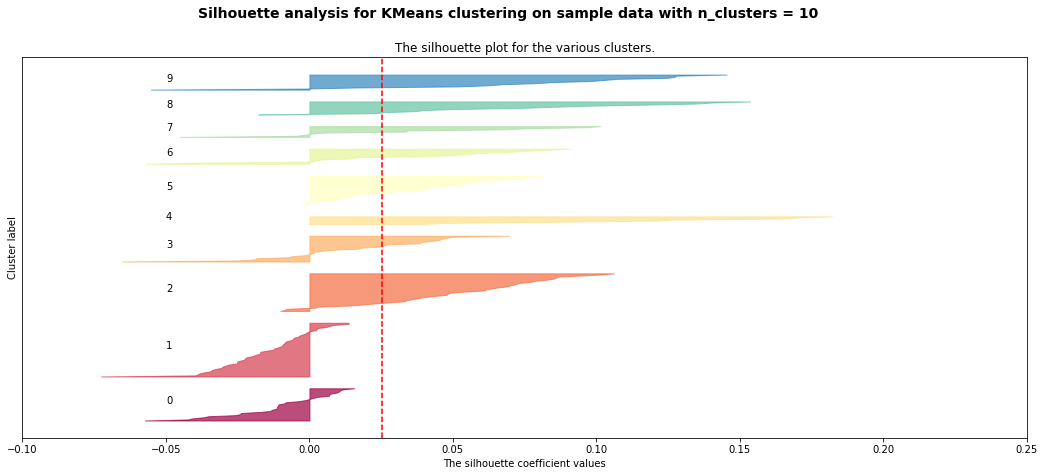

In [14]:
print(__doc__)

X = tfidf_matrix

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    clusterer = KMeans(n_clusters=n_clusters, random_state=30,
                       max_iter=3000, n_init=30, tol=1e-5)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

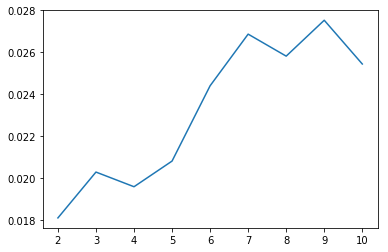

In [15]:
import matplotlib
silhouette_test = [0.01809096755035221, 0.02027967545815372, 0.019579725486279873, 0.020804531028335436,
                   0.024398475870632035, 0.02686430535205623, 0.025813674487533064, 0.02752714466218912, 0.025438605419956403]
y = range(2, 11)
matplotlib.pyplot.plot(y, silhouette_test)

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X = tfidf_matrix

cluster_range = range(2, 50)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters ,max_iter=2000, n_init=30,tol=1e-5)
    clusters.fit( X )
    cluster_errors.append( clusters.inertia_ )
    
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors":cluster_errors})


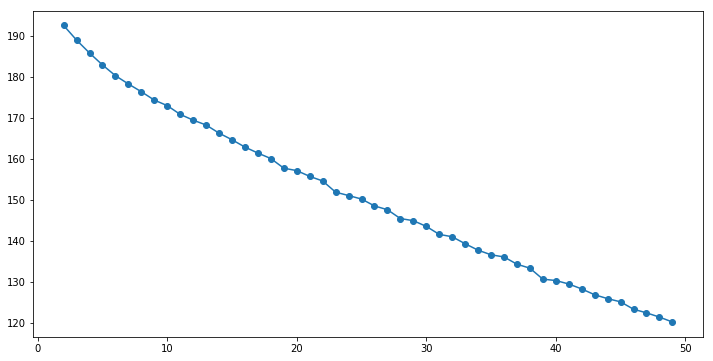

In [18]:
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_errors,marker = 'o')